In [1]:
# read in csv

import pandas as pd

data_df = pd.read_csv('deception_data.tsv', delimiter='\t')
data_df

,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very..."
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,"'After I went shopping with some of my friend,..."
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...
...,...,...,...
87,t,p,'Pastablities is a locally owned restaurant in...
88,t,p,'I like the Pizza at Dominoes for their specia...
89,t,p,'It was a really amazing Japanese restaurant. ...
90,t,p,'How do I even pick a best experience at Joe\'...


In [2]:
# clean the text

import spacy
nlp = spacy.load('en_core_web_sm')

def clean_text(text_):
    
    doc = nlp(text_)

    tokens = [i.text for i in doc if not i.is_punct | i.is_stop | i.like_num]

    tokens = ' '.join(tokens)
    return tokens

data_df['cleaned'] = data_df.review.apply(lambda x: clean_text(x))
data_df.head(3)

,lie,sentiment,review,cleaned
0,f,n,"'Mike\'s Pizza High Point, NY Service was very...",Mike\ Pizza High Point NY Service slow quality...
1,f,n,'i really like this buffet restaurant in Marsh...,like buffet restaurant Marshall street lot sel...
2,f,n,"'After I went shopping with some of my friend,...",went shopping friend went DODO restaurant dinn...


In [3]:
# split data

from sklearn.model_selection import train_test_split

def split_data(df_, x, y, test_size):
    y_vals = data_df[y].values
    x_vals = data_df[x].values

    x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=test_size, random_state=0)

    return  x_train, x_test, y_train, y_test


# Sentiment prediction: Baseline Accuracy 50%

In [4]:
print(data_df.groupby(by='sentiment').size())

sentiment
n    46
p    46
dtype: int64


In [5]:
# Split the data by sentiment

# pre cleaned text
x_sent_train, x_sent_test, y_sent_train, y_sent_test = split_data(data_df, 'review','sentiment', test_size=.3)

print(x_sent_train.shape, x_sent_test.shape, y_sent_train.shape, y_sent_test.shape)
print(x_sent_train[0])
print(y_sent_train[0])
print(x_sent_test[0])
print(y_sent_test[0])

# cleaned text
x_sent_train_clean, x_sent_test_clean, y_sent_train_clean, y_sent_test_clean = split_data(data_df, 'cleaned','sentiment', .7)



(64,) (28,) (64,) (28,)
'The restaurant looked pretty good, the people around me all ate and talked happily. The environment was comfortable and it calmed me down from the busy life. The food tasted fantastic and the price was suitable'
p
'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'
n


In [6]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# initialize vectorizer
count_vec = CountVectorizer(binary=False)
gram12_count_vec = CountVectorizer(binary=False, ngram_range=(1,2), max_df=.8)
tfidf_vec = TfidfVectorizer()


# vectorize training data
x_train_vec_1gram  = count_vec.fit_transform(x_sent_train_clean)
x_train_vec_12gram = gram12_count_vec.fit_transform(x_sent_train_clean)
x_train_vec_tfidf  = tfidf_vec.fit_transform(x_sent_train_clean)


# vectorize test data
x_test_vec_1gram  = count_vec.transform(x_sent_test_clean)
x_test_vec_12gram = gram12_count_vec.transform(x_sent_test_clean)
x_test_vec_tfidf  = tfidf_vec.transform(x_sent_test_clean)

In [7]:
type(count_vec.get_feature_names())

list

In [8]:
# fit model using cross-validation

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline

# initialize model
mnb_model = MultinomialNB()

# train model using cross validation
scores_1gram  = cross_val_score(mnb_model, x_train_vec_1gram,  y_sent_train_clean, cv = 5)
scores_12gram = cross_val_score(mnb_model, x_train_vec_12gram, y_sent_train_clean, cv = 5)
scores_tfidf  = cross_val_score(mnb_model, x_train_vec_tfidf,  y_sent_train_clean, cv = 5)

# print out validation scores
print('unigram: ', sum(scores_1gram)/ len(scores_1gram))
print('1&2gram: ', sum(scores_12gram)/len(scores_12gram))
print('tfidf: ',   sum(scores_tfidf)/ len(scores_tfidf))

# Unigrams seem to perform the best

unigram:  0.8666666666666666
1&2gram:  0.8266666666666665
tfidf:  0.5933333333333334


In [9]:
# get top features

from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer

mnb_1gram = MultinomialNB()

mnb_1gram.fit(x_train_vec_1gram, y_sent_train_clean)

feature_ranks_n = sorted(zip(mnb_1gram.feature_log_prob_[0], count_vec.get_feature_names()))
top_10_n = feature_ranks_n[-10:]
print(tabulate(top_10_n))

feature_ranks_p = sorted(zip(mnb_1gram.feature_log_prob_[1], count_vec.get_feature_names()))
top_10_p = feature_ranks_p[-10:]
print(tabulate(top_10_p))

--------  ----------
-5.33754  service
-5.33754  terrible
-5.33754  took
-5.18339  tofu
-5.18339  wasn
-5.18339  went
-5.04986  waitress
-4.82671  place
-4.7314   restaurant
-4.35671  food
--------  ----------
--------  ----------
-5.23733  fresh
-5.23733  friendly
-5.23733  pizza
-5.08318  amazing
-5.08318  it
-5.08318  like
-5.08318  place
-4.54418  restaurant
-4.46414  best
-4.32104  food
--------  ----------


Text(0.5, 1.0, 'Multinomial Bayes Sentiment')

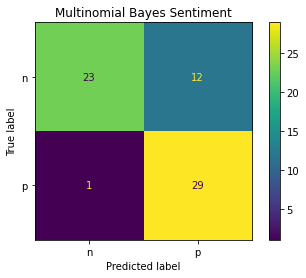

In [10]:
# Test Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mnb_1gram.score(x_test_vec_1gram, y_sent_test_clean)

y_pred = mnb_1gram.fit(x_train_vec_1gram, y_sent_train_clean).predict(x_test_vec_1gram)
cm=confusion_matrix(y_sent_test_clean, y_pred, labels=['n','p'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb_1gram.classes_)

disp.plot()
plt.title('Multinomial Bayes Sentiment')

In [11]:
# error Analysis
from sklearn.metrics import precision_recall_fscore_support

scores = precision_recall_fscore_support(y_sent_test_clean, y_pred, beta=1)

precision_n = scores[0][0]
precision_p = scores[0][1]

recall_n = scores[1][0]
recall_p = scores[1][1]

f1_n = scores[2][0]
f1_p = scores[2][1]

print(scores[:3])

print(tabulate(scores[:3], 
                headers=['negative','positive'],
                 showindex=['precision','recall','f1']))


(array([0.95833333, 0.70731707]), array([0.65714286, 0.96666667]), array([0.77966102, 0.81690141]))
             negative    positive
---------  ----------  ----------
precision    0.958333    0.707317
recall       0.657143    0.966667
f1           0.779661    0.816901


# Fake Review Prediction

In [12]:
# Baseline accuracy

data_df.groupby(by = 'lie').size()



lie
f    46
t    46
dtype: int64

## Baseline accuracy 50%

In [13]:
# split data by Lie

x_lie_train, x_lie_test, y_lie_train, y_lie_test = split_data(data_df, 'cleaned','lie', test_size=.3)

print(x_lie_train.shape, x_lie_test.shape, y_lie_train.shape, y_lie_test.shape)

print(x_lie_train[0])
print(y_lie_train[0])
print(x_lie_test[0])
print(y_lie_test[0])

(64,) (28,) (64,) (28,)
restaurant looked pretty good people ate talked happily environment comfortable calmed busy life food tasted fantastic price suitable
t
went shopping friend went DODO restaurant dinner found worm dishes
f


In [14]:
# Vectorize

# initialize vectorizer
count_vec = CountVectorizer(binary=False)
gram12_count_vec = CountVectorizer(binary=False, ngram_range=(1,2), max_df=.9)
tfidf_vec = TfidfVectorizer()


# vectorize training data
x_train_vec_1gram  = count_vec.fit_transform(x_lie_train)
x_train_vec_12gram = gram12_count_vec.fit_transform(x_lie_train)
x_train_vec_tfidf  = tfidf_vec.fit_transform(x_lie_train)
x_train_vec_tfidf_12g = tfidf_vec.fit_transform(x_lie_train)


# vectorize test data
x_test_vec_1gram  = count_vec.transform(x_lie_test)
x_test_vec_12gram = gram12_count_vec.transform(x_lie_test)
x_test_vec_tfidf  = tfidf_vec.transform(x_lie_test)



In [15]:
# Fit model

# initialize

mnb_model_lie = MultinomialNB()

# train models using cross validation
scores_1gram_lie  = cross_val_score(mnb_model_lie, x_train_vec_1gram,  y_lie_train, cv = 5)
scores_12gram_lie = cross_val_score(mnb_model_lie, x_train_vec_12gram, y_lie_train, cv = 5)
scores_tfidf_lie  = cross_val_score(mnb_model_lie, x_train_vec_tfidf,  y_lie_train, cv = 5)

# print out validation scores
print('unigram: ', sum(scores_1gram_lie)/ len(scores_1gram_lie))
print('1&2gram: ', sum(scores_12gram_lie)/len(scores_12gram_lie))
print('tfidf: ',   sum(scores_tfidf_lie)/ len(scores_tfidf_lie))

# tfidf works best

unigram:  0.526923076923077
1&2gram:  0.49743589743589745
tfidf:  0.5448717948717948


In [22]:
# get top features

mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(x_train_vec_tfidf_12g, y_lie_train)

print(mnb_tfidf.classes_)
feature_ranks_T = sorted(zip(mnb_tfidf.feature_log_prob_[0], count_vec.get_feature_names()))
feature_ranks_L = sorted(zip(mnb_tfidf.feature_log_prob_[1], count_vec.get_feature_names()))

top_10_T = feature_ranks_T[-10:]
top_10_F = feature_ranks_L[-10:]

print(tabulate(top_10_T, headers=['prob','top_true']))
print(tabulate(top_10_F, headers=['prob','top_false']))

['f' 't']
    prob  top_true
--------  ----------
-6.28974  menu
-6.28932  like
-6.28032  want
-6.27969  minutes
-6.27381  experience
-6.18572  place
-6.16904  service
-6.12365  best
-6.0714   restaurant
-5.96578  food
    prob  top_false
--------  -----------
-6.39949  pizza
-6.38895  waiter
-6.38891  environment
-6.37084  dishes
-6.32901  salad
-6.32804  ordered
-6.24771  place
-6.15768  good
-5.98565  food
-5.80675  restaurant


Text(0.5, 1.0, 'Multinomial Bayes Lie')

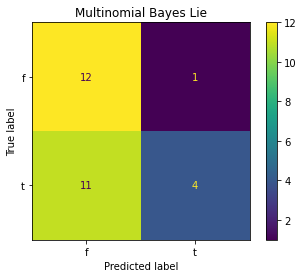

In [25]:
# Test Model

mnb_tfidf.score(x_test_vec_tfidf, y_lie_test)

y_pred = mnb_tfidf.fit(x_train_vec_tfidf, y_lie_train).predict(x_test_vec_tfidf)
cm = confusion_matrix(y_lie_test, y_pred, labels=['f','t'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb_tfidf.classes_)

disp.plot()
plt.title('Multinomial Bayes Lie')

In [27]:
# Error Analysis

scores = precision_recall_fscore_support(y_lie_test, y_pred, beta=1)

precision_f = scores[0][0]
precision_t = scores[0][1]

recall_f = scores[1][0]
recall_t = scores[1][1]

f1_f = scores[2][0]
f1_t = scores[2][1]

print(scores[:3])

print(tabulate(scores[:3], 
                headers=['False','True'],
                 showindex=['precision','recall','f1']))


(array([0.52173913, 0.8       ]), array([0.92307692, 0.26666667]), array([0.66666667, 0.4       ]))
              False      True
---------  --------  --------
precision  0.521739  0.8
recall     0.923077  0.266667
f1         0.666667  0.4
